# P4 Notebook

"a (single!) supporting notebook is also expected and will be graded."

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline
# sns.set_theme()

custom_hlegend = dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
)
FIGURE_WIDTH=950
FIGURE_HEIGHT=600

In [2]:
data_address = 'data/'

paper_data = pd.read_csv(f'{data_address}SambnisImp.csv')
paper_data['ccode'] = paper_data['cowcode']         # interoperability with teammates
var_filter =  ["ccode", "year", "warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]
paper_data = paper_data[var_filter]

national_trade_data = pd.read_csv(f'{data_address}National_COW_4.0.csv')
national_trade_data = national_trade_data[['year', 'ccode', 'imports', 'exports']]

inter_war = pd.read_csv(f'{data_address}Inter-StateWar.csv')
inter_war = inter_war.rename(columns={'CcodeA':'ccode'})

civil_war = pd.read_csv(f'{data_address}civil_wars.csv', encoding='latin-1')
civil_war = civil_war.rename(columns={
    'CcodeA':'ccode',
    'StartYr1':'StartYear1',
    'EndYr1':'EndYear1',
    'StartYr2':'StartYear2',
    'EndYr2':'EndYear2',
})

country_codes = (pd.read_csv(f'{data_address}country_codes.csv')
    .rename(columns={'CCode':'ccode'})
    .set_index('ccode')
)

In [3]:

# build war status
def build_war_state():
    # DB dates
    start_year = 1800
    end_year = 2020
    duration = end_year-start_year+1

    # initialize values
    at_war = np.zeros((1000, duration), dtype=np.int16)
    new_war = np.zeros((1000, duration), dtype=np.int16)
    year_at_war = np.zeros((1000, duration), dtype=np.int16)
    from_prev_war = np.zeros((1000, duration), dtype=np.int16)
    till_next_war = np.zeros((1000, duration), dtype=np.int16)

    
    for db in [civil_war, inter_war]:
        for row in db.itertuples():
            # compute the war period
            year_range = list(range(int(row.StartYear1), int(row.EndYear1)+1))
            if not pd.isna(row.StartYear2) and row.StartYear2 > 0:
                year_range += list(range(int(row.StartYear2), int(row.EndYear2)+1))
            # civil war can go up to startyear4

            # make sure ccode is valid
            if not pd.isna(row.ccode) and row.ccode > 0 and row.ccode < 1000:
                # print(f'add war: {len(year_range)}years , {ccode}-{ccode}.')
                new_war[int(row.ccode)][row.StartYear1 - start_year] = 1
                for year in year_range:
                    if year >= start_year and year <= end_year:
                        at_war[int(row.ccode)][year - start_year] = 1

    # compute stats about past/future wars per country
    unknown_value = 999
    for country in range(1000):
        year_at_war[country][0] = at_war[country][0]
        for year in range(1, duration):
            if at_war[country][year]:
                year_at_war[country][year] = year_at_war[country][year-1]+1
        last_war = 0
        for year in range(duration):
            if at_war[country][year]:
                last_war = year
            from_prev_war[country][year] = year - last_war if last_war else unknown_value
        comming_war = 0
        for year in range(duration)[::-1]:
            if at_war[country][year]:
                comming_war = year
            till_next_war[country][year] = comming_war - year if comming_war else unknown_value

    # repack as dataframe
    df = pd.DataFrame([
        {
            'year':start_year+year, 
            'ccode':country,
            'at_war':at_war[country][year],
            'year_at_war':year_at_war[country][year],
            'from_prev_war':from_prev_war[country][year],
            'till_next_war':till_next_war[country][year],
            'war_start_hard':new_war[country][year]==1,
            'war_start_soft':(
                new_war[country][year-1]==1 or 
                new_war[country][year]==1 or 
                new_war[country][year+1]==1 
            ),
        } 
        for country in country_codes.index
        for year in range(1, duration-1)
    ])
    return df

# Unknown values are represented as 999
war_state = build_war_state()


In [4]:
# process annual growth 
def add_annual_change(df, columns, periods=[1]):
    # new_columns_names = []
    country_dfs = {}
    for country in country_codes.index:
        c_df = df[df['ccode']==country]
        for period in periods:
            for column in columns:
                name = f'{column}_growth{"" if period == 1 else f"_{period}years"}'
                # print(name)
                c_df[name] = c_df[column].pct_change(period)*100
                # new_columns_names.append(name)
        country_dfs[country] = c_df

    data = pd.concat(country_dfs.values())
    # Annual changes for (0,0) values results in Nan
    data.fillna('0', inplace=True)
    return data


In [5]:

# process trade data
national_trade_data = pd.read_csv(f'{data_address}National_COW_4.0.csv')
national_trade_data = national_trade_data[['year', 'ccode', 'imports', 'exports']]
ntrade_no_nan_data = national_trade_data.copy()

# Add net trade
national_trade_data['net'] = national_trade_data['exports'] - national_trade_data['imports']
# add annual growth
national_trade_data = add_annual_change(
    national_trade_data, 
    ['imports', 'exports', 'net'], 
    [1, 2, 3]
)

for c in national_trade_data.columns[2:]:
    national_trade_data[c] = pd.to_numeric(national_trade_data[c])


In [6]:

# Build a no-nan trade version
# Fix NA values
# Drop NA values
ntrade_no_nan_data.dropna(inplace=True)
# Add net trade
ntrade_no_nan_data['net'] = ntrade_no_nan_data['exports'] - ntrade_no_nan_data['imports']
# Change format to wide
wide_trade = ntrade_no_nan_data.pivot(
    index='year', 
    columns='ccode', 
    values=['imports', 'exports', 'net']
)
# Use next year's trade value to fill
wide_trade = (wide_trade
    .fillna(method='bfill') # Fill data with the next value
    .fillna(method='ffill') # if data missing at the end
    .reset_index()
    .melt(id_vars='year')
)
# bring back to the long format
wide_trade = wide_trade.rename(columns={wide_trade.columns[1]:'direction'})
ntrade_no_nan_data = wide_trade.pivot(
    index=['year', 'ccode'], 
    columns='direction', 
    values='value'
).reset_index()

# drop two countries with less than 3 measurements
ntrade_no_nan_data.drop(
    ntrade_no_nan_data[ntrade_no_nan_data['ccode'].isin([451,517])].index,
    inplace=True
)
# add annual growth
ntrade_no_nan_data = add_annual_change(
    ntrade_no_nan_data, 
    ['imports', 'exports', 'net'], 
    [1, 2, 3]
)

# fills the remaining two Nan cells with zero
ntrade_no_nan_data.fillna(0., inplace=True)

In [7]:

# Extend the original data

# ****** IMPORTANT ******
# This new data contains leakage about upcoming year.
# This is useful for re-targeting the prediction, but should be handled with care 
# Leaky column: 'at_war', 'year_at_war', 'till_next_war, 'war_start_hard', 'war_start_soft'
# Targets: 'war_start_hard' a new war starts this year
# Targets: 'war_start_soft' a new war starts in with -/+ 1 year tolerance
extended_paper_data = pd.merge(paper_data, war_state, how='left', on=['ccode', 'year'])

# Add annual changes
interesting_growth_fields = ['agexp', 'army85', 'expgdp', 'fuelexp', 'gdpgrowth',
    'infant', 'life', 'manuexp', 'milper', 'trade']

extended_paper_data = add_annual_change(
    extended_paper_data, 
    interesting_growth_fields, 
    [1, 2, 3]
)

# Add trade data
extended_paper_data = pd.merge(
    extended_paper_data, 
    ntrade_no_nan_data, 
    how='left', 
    on=['ccode', 'year']
)
# Does not have trade data for all countries
extended_paper_data.fillna('0', inplace=True)

In [12]:
# how many countries are on each side of a war
sides_of_war = (inter_war
    .groupby(['WarNum', 'Side'])
    .count()
    .reset_index()
    .pivot(index='WarNum', columns='Side', values='WarName')
    .rename(columns={1:'SideA', 2:'SideB'})
)
sides_of_war['SideMax'] = sides_of_war[['SideA', 'SideB']].max(axis=1)
sides_of_war['SideMin'] = sides_of_war[['SideA', 'SideB']].min(axis=1)
sides_of_war['ratio'] = sides_of_war['SideMax']/sides_of_war['SideMin']


unfair_wars = pd.merge(inter_war, sides_of_war[['SideMin', 'SideMax',  'ratio']], left_on='WarNum', right_index=True)
fig = px.sunburst(unfair_wars, path=[ 'SideMax', 'SideMin', 'WarName'],  width=FIGURE_WIDTH, height=FIGURE_HEIGHT)
fig.write_html('fig/sides.html', include_plotlyjs='cdn', full_html=False)
fig.show()

In [13]:
def plot_country_trade(cowcode):
    country_name = country_codes.loc[cowcode]['StateNme']
    trade_df = (national_trade_data[national_trade_data['ccode']==cowcode]
        .copy()
        .dropna()
        .rename(columns={'exports_growth':'Export', 'imports_growth':'Import'})
    )
    war_df = inter_war[inter_war['ccode']==cowcode]

    fig = px.line(
        trade_df, x="year", 
        # y=["exports_growth", "imports_growth"], 
        y=['Export', 'Import'],
        width=FIGURE_WIDTH, 
        height=FIGURE_HEIGHT
    )

    fig.add_trace(go.Scatter(
        x=war_df['StartYear1'],
        y=[-90]*len(war_df),
        mode='markers',
        text=war_df['WarName'], 
        marker_symbol='star',
        marker_line_color="rgba(255,0,0,1)", 
        marker_color="rgba(255,0,0,0.25)",
        marker_line_width=2, 
        marker_size=10,
        name='Wars',
    ))
    
    fig.update_layout(
        xaxis=dict(
            rangeslider=dict(
                visible=True
            ),
        ),
        title=f"Trade and war in {country_name}",
        xaxis_title="year",
        yaxis_title="% growth from last year",
        legend=custom_hlegend,
        width=950,
        height=600
    )
    fig.update_yaxes(range=[-100, 100])
    fig.update_xaxes(range=[1870,2015])
    fig.write_html(f'fig/country_trade_{cowcode}.html', include_plotlyjs='cdn', full_html=False)
    fig.show()
plot_country_trade(2)  
plot_country_trade(200)  
plot_country_trade(700)  

In [14]:

trade_data= national_trade_data.copy()
trade_data = pd.merge(
    trade_data, 
    war_state, 
    how='left', 
    on=['ccode', 'year']
)

countries_with_war = list(set(trade_data[trade_data['at_war']==1]['ccode'].values))
trade_data[trade_data['ccode'].isin(countries_with_war)]

peace_trade = trade_data[trade_data['at_war']==0]
war_trade = trade_data[trade_data['at_war']==1]

features = {
    'median_imports_growth':('imports_growth', 'median'),
    'median_exports_growth':('exports_growth', 'median'),
    'q1_imports_growth':('imports_growth',  lambda x: x.quantile(0.25)),
    'q1_exports_growth':('exports_growth',  lambda x: x.quantile(0.25)),
    'q3_imports_growth':('imports_growth',  lambda x: x.quantile(0.75)),
    'q3_exports_growth':('exports_growth',  lambda x: x.quantile(0.75)),
}

peace_trade_year = peace_trade.groupby(['year']).agg(**features).reset_index()
war_trade_year = war_trade.groupby(['year']).agg(**features).reset_index()
wp_trade_year = trade_data.groupby(['year', 'at_war']).agg(**features).reset_index()

In [15]:
# Plot global trade trends

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=wp_trade_year['year'],
    y=wp_trade_year['median_exports_growth'],
    line_color='blue',
    name='Export',
))
fig.add_trace(go.Scatter(
    x=wp_trade_year['year'],
    y=wp_trade_year['median_imports_growth'],
    line_color='red',
    name='Import',
))
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    legend=custom_hlegend,
    title=f"Global trade over years",
    xaxis_title="year",
    yaxis_title="Median % growth from last year between countries",
    width=FIGURE_WIDTH, 
    height=FIGURE_HEIGHT,
)
fig.update_yaxes(range=[-60, 100])
fig.write_html('fig/global_trade.html', include_plotlyjs='cdn', full_html=False)
fig.show()

In [27]:
# plot war and trade
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=war_trade_year['year'],
    y=war_trade_year['q1_imports_growth'],
    fill='none',
    line_color='rgba(0,0,255,0.2)',
    showlegend=False,
    name='war',
))
fig.add_trace(go.Scatter(
    x=war_trade_year['year'],
    y=war_trade_year['q3_imports_growth'],
    fill='tonexty',
    fillcolor='rgba(0,0,255,0.2)',
    line_color='rgba(0,0,255,0.2)',
    showlegend=False,
    name='war',
))
fig.add_trace(go.Scatter(
    x=war_trade_year['year'],
    y=war_trade_year['median_imports_growth'],
    line_color='rgb(0,0,255)',
    name='war',
))

fig.add_trace(go.Scatter(
    x=peace_trade_year['year'],
    y=peace_trade_year['q1_imports_growth'],
    fill='none',
    line_color='rgba(255,0,0,0.2)',
    showlegend=False,
    name='peace',
))
fig.add_trace(go.Scatter(
    x=peace_trade_year['year'],
    y=peace_trade_year['q3_imports_growth'],
    fill='tonexty',
    fillcolor='rgba(255,0,0,0.2)',
    line_color='rgba(255,0,0,0.2)',
    showlegend=False,
    name='peace',
))
fig.add_trace(go.Scatter(
    x=peace_trade_year['year'],
    y=peace_trade_year['median_imports_growth'],
    line_color='rgb(255,0,0)',
    name='peace',
))
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    legend=custom_hlegend,
    title=f"Impact of war on trade",
    xaxis_title="year",
    yaxis_title="[25%, Median, 75%] % growth from last year between countries",
    width=FIGURE_WIDTH, 
    height=FIGURE_HEIGHT
)
fig.update_yaxes(range=[-100, 100])
fig.update_traces(mode='lines')
fig.write_html('fig/war_trade.html', include_plotlyjs='cdn', full_html=False)
fig.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import collections
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve


In [ ]:
# Load extended data NOTE: HAS TO BE CLEANED FIRST
y_ex = extended_paper_data.warstds
X_ex = extended_paper_data[extended_paper_data.columns[8:]]
print(y_ex.shape)
print(X_ex.shape)

(8288,)
(8288, 330)


In [ ]:
# Reduced original dataset
feature_filter = ["cowcode", "year", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]

In [ ]:
# Full paper data
y = paper_data.warstds
#X = paper_data[paper_data.columns[8:]]
X = paper_data[feature_filter].loc[:, paper_data[feature_filter].columns != 'warstds']
X_full = paper_data.loc[:, paper_data.columns != 'warstds']

#X = paper_data[feature_filter]
print(y.shape)
print(X.shape)

(7140,)
(7140, 92)


In [ ]:
X.head()

,cowcode,year,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,coldwar,decade1,decade2,decade3,decade4,dem,dem4,demch98,dlang,drel,durable,ef,ef2,ehet,elfo,elfo2,etdo4590,expgdp,exrec,fedpol3,fuelexp,gdpgrowth,geo1,geo2,geo34,geo57,geo69,geo8,illiteracy,...,mirps1,mirps2,mirps3,nat_war,ncontig,nmgdp,nmdp4_alt,numlang,nwstate,oil,p4mchg,parcomp,parreg,part,partfree,plural,plurrel,pol4,pol4m,pol4sq,polch98,polcomp,popdense,presi,pri,proxregc,ptime,reg,regd4_alt,relfrac,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,700,1945,34.461765,8.510845,0,129472.9042,0,3.925812,0.005151,0.432955,1,1,0,0,0,0,0,3.995929,0,70.0,20.0,20.909713,0.750797,0.563696,90.0,66.0,2212.227998,1.0,33.592410,5.292369,0.132263,15.387903,0.022562,0.0,0.0,0.0,1.0,0.0,0.0,34.020639,...,0.16935,0.313143,0.373714,0,0.0,4508.131692,-0.475189,8.0,0.0,0,0.051008,2.733729,3.835219,2.43732,0,0.38,84.0,0.070117,0.068564,61.493014,0,5.059323,118.554791,0,87.931355,0.143299,12,0.581817,-0.413956,0.2718,43.770298,0.253,0.058441,0.46176,0.158275,0.052989,0.443259,72.881375,0,3.995912
1,700,1946,34.346348,8.478997,0,129413.0225,0,10.000000,0.000000,0.045052,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2219.468491,1.0,33.561559,1.000000,0.000000,15.594645,0.022447,0.0,0.0,0.0,1.0,0.0,0.0,34.129908,...,0.00000,1.000000,0.000000,1,0.0,4491.340308,-5.000000,8.0,0.0,0,0.053837,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,117.756342,0,88.007471,1.000000,24,0.585308,-3.000000,0.2718,43.588363,0.253,0.000000,0.00000,0.158321,0.052663,1.000000,72.900089,0,1.000000
2,700,1947,77.000000,8.481015,0,130431.0145,0,10.000000,0.000000,0.030034,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2219.825536,1.0,33.577128,1.000000,0.000000,15.601810,0.022372,0.0,0.0,0.0,1.0,0.0,0.0,34.183272,...,0.00000,1.000000,0.000000,1,0.0,4484.267686,-5.000000,8.0,0.0,0,0.000000,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,118.280656,0,87.972309,1.000000,36,1.000000,-3.000000,0.2718,43.538181,0.253,0.000000,0.00000,0.158425,0.052891,2.000000,72.962880,0,1.000000
3,700,1948,78.000000,8.451628,0,126781.6866,0,10.000000,0.000000,0.022526,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2225.284783,1.0,33.625990,1.000000,0.000000,15.739340,0.022239,0.0,0.0,0.0,1.0,0.0,0.0,34.234445,...,0.00000,1.000000,0.000000,1,0.0,4474.082672,-4.500000,8.0,0.0,0,0.000000,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,118.325869,0,87.885682,1.000000,48,1.000000,-3.500000,0.2718,43.490005,0.253,0.000000,0.00000,0.159006,0.052902,2.000000,73.102449,0,1.000000
4,700,1949,79.000000,8.500172,0,130979.2470,0,10.000000,0.000000,0.022526,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2216.878723,1.0,33.538608,1.000000,0.000000,15.525010,0.022462,0.0,0.0,0.0,1.0,0.0,0.0,34.164099,...,0.00000,1.000000,0.000000,1,0.0,4497.299503,-3.000000,8.0,0.0,0,0.000000,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,118.312296,0,87.947331,1.000000,60,1.000000,2.000000,0.2718,43.602238,0.253,0.000000,0.00000,0.158074,0.052706,2.000000,72.850389,0,1.000000


In [ ]:
# Split and define, fit, pred RF
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train_full = X_train.copy()
X_train = X_train[X_train.columns[2:]]

X_test_full = X_test.copy()
X_test = X_test[X_test.columns[2:]]

In [ ]:
# Split and define, fit, pred RF
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train_full = X_train.copy()
X_train = X_train[X_train.columns[7:]]

X_test_full = X_test.copy()
X_test = X_test[X_test.columns[7:]]


In [ ]:
print(X_train.shape)
print(X_train_full.shape)
print(X_test.shape)
print(X_test_full.shape)

(4998, 90)
(4998, 92)
(2142, 90)
(2142, 92)


In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100)
random_forest_clf.fit(X_train, y_train)
random_forest_scoring = random_forest_clf.predict(X_test)

In [ ]:
precision_recall_fscore_support(y_test, random_forest_scoring, average='binary')

(1.0, 0.022222222222222223, 0.04347826086956522, None)

In [ ]:
collections.Counter(random_forest_scoring)

Counter({0: 2141, 1: 1})

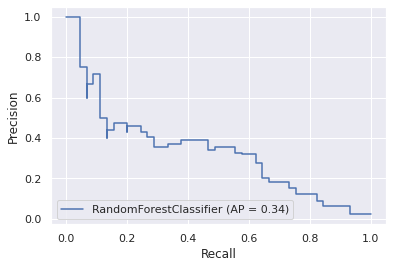

In [ ]:
plot_precision_recall_curve(random_forest_clf, X_test, y_test)

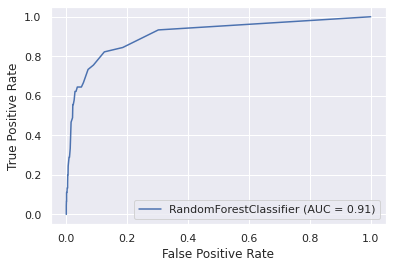

In [ ]:
plot_roc_curve(random_forest_clf, X_test, y_test)

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
# Perform on expanded data with mean replacement strategy
# Split and define, fit, pred RF
X_ex.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_ex, y_ex, test_size=0.3)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

random_forest_clf = RandomForestClassifier(n_estimators=100)

X_train_imp = imp.transform(X_train)
random_forest_clf.fit(X_train_imp, y_train)

X_test_imp = imp.transform(X_test)
random_forest_scoring = random_forest_clf.predict(X_test_imp)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
precision_recall_fscore_support(y_test, random_forest_scoring, average='binary')

(0.7333333333333333, 0.55, 0.6285714285714286, None)

In [ ]:
collections.Counter(random_forest_scoring)

Counter({0: 2457, 1: 30})

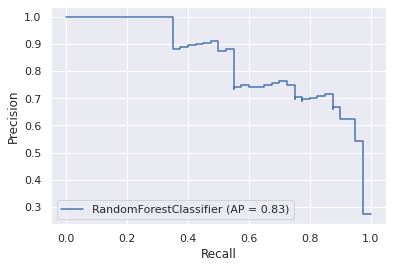

In [ ]:
plot_precision_recall_curve(random_forest_clf, X_test_imp, y_test)

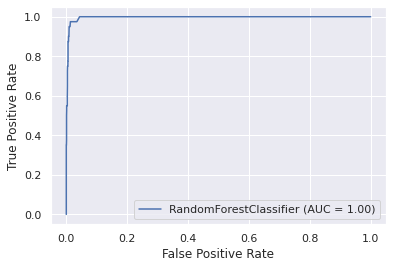

In [ ]:
plot_roc_curve(random_forest_clf, X_test_imp, y_test)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.impute import SimpleImputer

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=300, class_weight={0: 0.5, 1: 0.5})

In [ ]:
scoring = ['f1']
scores = cross_validate(random_forest_clf, X[X.columns[2:]], y, scoring=scoring)
scores

{'fit_time': array([3.57809782, 3.77468252, 3.84943056, 3.71438432, 3.73424816]),
 'score_time': array([0.04105449, 0.056494  , 0.05688739, 0.05681419, 0.05876541]),
 'test_f1': array([0.08333333, 0.08      , 0.07407407, 0.15384615, 0.07692308])}

In [ ]:
print(scores['test_f1'].mean())

0.09363532763532764


In [ ]:
scoring = ['f1']
scores = cross_validate(random_forest_clf, X_full[X_full.columns[7:]], y, scoring=scoring)
scores

{'fit_time': array([6.50778985, 6.84472227, 6.47429752, 6.17811799, 6.03826308]),
 'score_time': array([0.05453634, 0.05373192, 0.04106736, 0.05316305, 0.0543983 ]),
 'test_f1': array([0.65116279, 0.76923077, 0.61538462, 0.57894737, 0.66666667])}

In [ ]:
print(scores['test_f1'].mean())

0.6562784420801556


In [ ]:
X_ex.replace([np.inf, -np.inf], np.nan, inplace=True)


imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_ex)
X_ex_imp = imp.transform(X_ex)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
scores = cross_validate(random_forest_clf, X_ex_imp, y_ex, scoring=scoring)
scores

{'fit_time': array([ 9.5546782 , 10.67951918, 10.60102439, 10.19366002, 11.39090157]),
 'score_time': array([0.06262279, 0.05812407, 0.0644443 , 0.06393814, 0.05795836]),
 'test_f1': array([0.68421053, 0.57142857, 0.57777778, 0.55813953, 0.14886731])}

In [ ]:
print(scores['test_f1'].mean())

0.5080847448643435


## Skope-rules

In [ ]:
!pip install skope-rules

In [ ]:
from skrules import SkopeRules


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [ ]:
# Train a skope-rules-boosting classifier
# feature_names=paper_data.columns[8:]
skope_rules_clf = SkopeRules(feature_names=X_train.columns, n_estimators=100,
                               recall_min=0.2, precision_min=0.2,
                               max_depth_duplication= 4, max_depth = 5)
skope_rules_clf.fit(X_train, y_train)

SkopeRules(bootstrap=False, bootstrap_features=False,
           feature_names=Index(['ager', 'agexp', 'anoc', 'army85', 'autch98', 'auto4', 'autonomy',
       'avgnabo', 'centpol3', 'coldwar', 'decade1', 'decade2', 'decade3',
       'decade4', 'dem', 'dem4', 'demch98', 'dlang', 'drel', 'durable', 'ef',
       'ef2', 'ehet', 'elfo', 'elfo2', 'etdo4590', 'expgdp', 'exrec',
       'fedpol3', 'fuelexp', 'gdpgrowth', 'geo1...
       'polch98', 'polcomp', 'popdense', 'presi', 'pri', 'proxregc', 'ptime',
       'reg', 'regd4_alt', 'relfrac', 'seceduc', 'second', 'semipol3', 'sip2',
       'sxpnew', 'sxpsq', 'tnatwar', 'trade', 'warhist', 'xconst'],
      dtype='object'),
           max_depth=5, max_depth_duplication=4, max_features=1.0,
           max_samples=0.8, max_samples_features=1.0, min_samples_split=2,
           n_estimators=100, n_jobs=1, precision_min=0.2, random_state=None,
           recall_min=0.2, verbose=0)

In [ ]:
skope_rules_scoring = skope_rules_clf.score_top_rules(X_test)

In [ ]:
# Get number of rules created
print(str(len(skope_rules_clf.rules_)) + ' rules have been built with ' +
      'SkopeRules.\n')

6 rules have been built with SkopeRules.



In [ ]:
import json

for i_rule, rule in enumerate(skope_rules_clf.rules_[:9]):
    print(json.dumps(rule))

["agexp > 10.917234897613525 and nwstate <= 0.025939878076314926 and popdense > 73.18764877319336 and sxpnew <= 0.10493441298604012 and sxpnew > 0.10259348899126053", [0.45454545454545453, 0.2631578947368421, 1]]
["agexp > 9.26222562789917 and nwstate <= 0.02575663384050131 and popdense <= 101.7993278503418 and popdense > 73.18764877319336 and sxpsq > 0.022167881950736046", [0.5217391304347826, 0.21818181818181817, 1]]
["agexp > 11.1209135055542 and etdo4590 <= 0.6065419912338257 and mirps3 <= 0.27200382947921753 and nwstate <= 0.025939878076314926 and popdense > 73.18764877319336", [0.3, 0.3157894736842105, 1]]
["agexp > 9.264163970947266 and expgdp > 20.96492290496826 and nwstate <= 0.025939878076314926 and popdense <= 101.83086395263672 and popdense > 97.3112907409668", [0.5454545454545454, 0.20689655172413793, 1]]
["agexp > 9.260287284851074 and milper > 128.15564346313477 and nwstate <= 0.025939878076314926 and sxpnew <= 0.14166831225156784 and sxpsq > 0.022212110459804535", [0.40

In [ ]:
def compute_y_pred_from_query(X, rule):
    score = np.zeros(X.shape[0])
    X = X.reset_index(drop=True)
    score[list(X.query(rule).index)] = 1
    return(score)

def compute_performances_from_y_pred(y_true, y_pred, index_name='default_index'):
    df = pd.DataFrame(data=
        {
            'precision':[sum(y_true * y_pred)/sum(y_pred)],
            'recall':[sum(y_true * y_pred)/sum(y_true)]
        },
        index=[index_name],
        columns=['precision', 'recall']
    )
    return(df)

def compute_train_test_query_performances(X_train, y_train, X_test, y_test, rule):
    
    y_train_pred = compute_y_pred_from_query(X_train, rule)
    y_test_pred = compute_y_pred_from_query(X_test, rule)
    
    performances = None
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_train, y_train_pred, 'train_set')],
        axis=0)
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_test, y_test_pred, 'test_set')],
        axis=0)
            
    return(performances)

for i in range(6):
    print('Rule '+str(i+1)+':')
    display(compute_train_test_query_performances(X_train, y_train,
                                                  X_test, y_test,
                                                  skope_rules_clf.rules_[i][0])
           )

Rule 1:


,precision,recall
train_set,0.410256,0.225352
test_set,0.526316,0.222222


Rule 2:


,precision,recall
train_set,0.466667,0.197183
test_set,0.352941,0.133333


Rule 3:


,precision,recall
train_set,0.301370,0.309859
test_set,0.391304,0.200000


Rule 4:


,precision,recall
train_set,0.482759,0.197183
test_set,0.368421,0.155556


Rule 5:


,precision,recall
train_set,0.410256,0.225352
test_set,0.538462,0.155556


Rule 6:


,precision,recall
train_set,0.19802,0.281690
test_set,0.22449,0.244444


In [ ]:
import random

In [ ]:
for i_rule, rule in enumerate(skope_rules_clf.rules_[:6]):
  print(rule)
  scores = compute_y_pred_from_query(X_test, rule[0])
  #print(scores.shape)
  #print(y_test.shape)
  #print(X_test.shape)

  tp = []
  fp = []
  tn = []
  fn = []

  for i in range(len(scores)):
    if y_test.iloc[i] == scores[i] and scores[i] == 1:
      tp.append(country_codes._get_value(X_test_full.cowcode.to_numpy()[i], "StateNme") + " " + str(X_test_full.year.to_numpy()[i]))
    if y_test.iloc[i] != scores[i] and scores[i] == 1:
      try:
        fp.append(country_codes._get_value(X_test_full.cowcode.to_numpy()[i], "StateNme") + " " + str(X_test_full.year.to_numpy()[i]))
      except:
        fp.append(str(X_test_full.cowcode.to_numpy()[i]) + " " + str(X_test_full.year.to_numpy()[i]))
    if y_test.iloc[i] != scores[i] and scores[i] == 0:
      fn.append(country_codes._get_value(X_test_full.cowcode.to_numpy()[i], "StateNme") + " " + str(X_test_full.year.to_numpy()[i]))
    if y_test.iloc[i] == scores[i] and scores[i] == 0:
      try:
        tn.append(country_codes._get_value(X_test_full.cowcode.to_numpy()[i], "StateNme") + " " + str(X_test_full.year.to_numpy()[i]))
      except:
        tn.append(str(X_test_full.cowcode.to_numpy()[i]) + " " + str(X_test_full.year.to_numpy()[i]))

  tp_len = len(tp)
  fp_len = len(fp)
  tn_len = len(tn)
  fn_len = len(fn)

  # Fill it to have min pop of 10
  for k in range(10):
    if len(tp) < 10:
      tp.append("")
    if len(fp) < 10:
      fp.append("")
    if len(tn) < 10:
      tn.append("")
    if len(fn) < 10:
      fn.append("")

  no_wars = 10

  wars_tp = random.sample(tp, no_wars)
  wars_fp = random.sample(fp, no_wars)
  wars_tn = random.sample(tn, no_wars)
  wars_fn = random.sample(fn, no_wars)

  for j in range(no_wars):
    war_tp = wars_tp[j]
    if isinstance(war_tp, np.ndarray):
      wars_tp[j] = war_tp[0]
    war_fp = wars_fp[j]
    if isinstance(war_fp, np.ndarray):
      wars_fp[j] = war_fp[0]
    war_tn = wars_tn[j]
    if isinstance(war_tn, np.ndarray):
      wars_tn[j] = war_tn[0]
    war_fn = wars_fn[j]
    if isinstance(war_fn, np.ndarray):
      wars_fn[j] = war_fn[0]

  wars_tp = list(filter(lambda item: item != '', wars_tp))
  wars_fp = list(filter(lambda item: item != '', wars_fp))
  wars_tn = list(filter(lambda item: item != '', wars_tn))
  wars_fn = list(filter(lambda item: item != '', wars_fn))

  print('<thead><tr><th scope="col">TP (' + str(tp_len) + ')</th><th scope="col">TN (' + str(tn_len) + 
        ')</th><th scope="col">FN (' + str(fn_len) + ')</th><th scope="col">FP (' + str(fp_len) + ')</th></tr></thead>')
  print('<tbody>')
  for j in range(no_wars):
    if j >= len(wars_tp):
      war_tp = ''
    else:
      war_tp = wars_tp[j]

    if j >= len(wars_fp):
      war_fp = ''
    else:
      war_fp = wars_fp[j]

    if j >= len(wars_tn):
      war_tn = ''
    else:
      war_tn = wars_tn[j]

    if j >= len(wars_fn):
      war_fn = ''
    else:
      war_fn = wars_fn[j]

    print('<tr><td>' + war_tp + '</td><td>' + war_tn + '</td><td>' + war_fn + '</td><td>' + war_fp + '</td></tr>')
  print('</tbody>')

('agexp > 10.917234897613525 and nwstate <= 0.025939878076314926 and popdense > 73.18764877319336 and sxpnew <= 0.10493441298604012 and sxpnew > 0.10259348899126053', (0.45454545454545453, 0.2631578947368421, 1))
<thead><tr><th scope="col">TP (10)</th><th scope="col">TN (2088)</th><th scope="col">FN (35)</th><th scope="col">FP (9)</th></tr></thead>
<tbody>
<tr><td>Laos 1960</td><td>Norway 1963</td><td>Guatemala 1978</td><td>Colombia 1958</td></tr>
<tr><td>China 1950</td><td>Liberia 1983</td><td>Algeria 1962</td><td>Colombia 1950</td></tr>
<tr><td>Burundi 1965</td><td>364 1977</td><td>Sudan 1983</td><td>China 1956</td></tr>
<tr><td>Indonesia 1953</td><td>Uruguay 1966</td><td>Sri Lanka 1971</td><td>Congo 1998</td></tr>
<tr><td>Burundi 1988</td><td>818 1985</td><td>Peru 1982</td><td>Kosovo 1999</td></tr>
<tr><td>Iraq 1959</td><td>Sudan 1959</td><td>Thailand 1967</td><td>Ethiopia 1977</td></tr>
<tr><td>Paraguay 1947</td><td>Colombia 1978</td><td>Tajikistan 1992</td><td>Colombia 1956</td></

In [ ]:
n_rule_chosen = 6
y_pred = skope_rules_clf.predict_top_rules(X_test, n_rule_chosen)

print('The performances reached with '+str(n_rule_chosen)+' discovered rules are the following:')
compute_performances_from_y_pred(y_test, y_pred, 'test_set')
precision_recall_fscore_support(y_test, y_pred, average='binary')

The performances reached with 6 discovered rules are the following:


(0.18181818181818182, 0.3111111111111111, 0.22950819672131148, None)